In [1]:
import json
import os 
import scipy.io
import random
from sklearn.preprocessing import MinMaxScaler # normalize the x,y coordinates
import networkx as nx # for graph
import matplotlib.pyplot as plt
import numpy as np
from generate_graphs import graph_sequence, load_file
from helper_funcs import evaluate_frame, adjacency_matrix
import warnings
from sklearn.decomposition import PCA
warnings.filterwarnings("ignore")

Define the nodes for the poses

In [2]:
graph = dict() # initialize graph

points = []
# read the landmarks.m file
with open('landmarks\horse\landmarks.m', 'r') as f:
    for i in f:
        split_result = i.split(' = ')
        if len(split_result) >= 2:
            # print(split_result[1].split(';')[0])
            points.append(split_result[1].split(';')[0].split("'")[1])

# add points to graph
graph['chin'] = ['leftEye', 'rightEye', 'neck']
graph['rightEye'] = ['chin', 'leftEye', 'neck']
graph['leftEye'] = ['chin', 'rightEye', 'neck']
graph['neck'] = ['chin', 'leftEye', 'rightEye', 'leftShoulder', 'rightShoulder']
graph['leftShoulder'] = ['neck', 'frontLeftHip', 'tailStart']
graph['rightShoulder'] = ['neck', 'frontRightHip', 'tailStart']
graph['frontLeftHip'] = ['leftShoulder', 'frontLeftKnee']
graph['frontRightHip'] = ['rightShoulder', 'frontRightKnee']
graph['frontLeftKnee'] = ['frontLeftHip', 'frontLeftHoof']
graph['frontRightKnee'] = ['frontRightHip', 'frontRightHoof']
graph['frontLeftHoof'] = ['frontLeftKnee']
graph['frontRightHoof'] = ['frontRightKnee']
graph['tailStart'] = ['leftShoulder', 'rightShoulder', 'backLeftHip', 'backRightHip']
graph['backLeftHip'] = ['tailStart', 'backLeftKnee']
graph['backRightHip'] = ['tailStart', 'backRightKnee']
graph['backLeftKnee'] = ['backLeftHip', 'backLeftHoof']
graph['backRightKnee'] = ['backRightHip', 'backRightHoof']
graph['backLeftHoof'] = ['backLeftKnee']
graph['backRightHoof'] = ['backRightKnee']

len(graph) == len(points) # check that all points are in graph

True

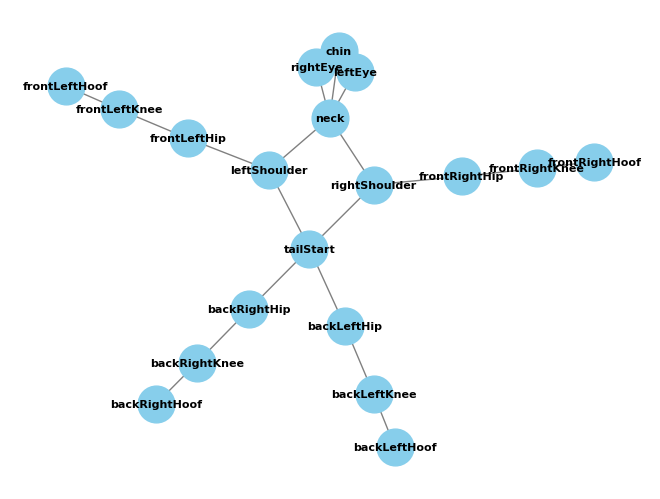

In [3]:
# Create a graph
graph_network = nx.Graph(graph)


# Draw the graph
# pos = nx.spring_layout(graph_network)  # You can choose a different layout algorithm
nx.draw(graph_network, with_labels=True, font_weight='bold', node_size=700, 
        node_color='skyblue', font_color='black', font_size=8, edge_color='gray')

# Display the graph
plt.show()


In [4]:
# save dictionary to JSON file
with open('behavoiur-discovery/graph.json', 'w') as fp:
    json.dump(graph, fp, indent=4)

Define rules to connect the nodes
1. Load the .mat files 
2. Create a graph for each frame and a queue for each file
3. Normalize the x,y coordinates

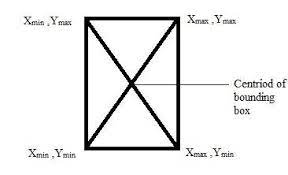

In [2]:
# get the graph for the landmarks data
graph_seq = graph_sequence()

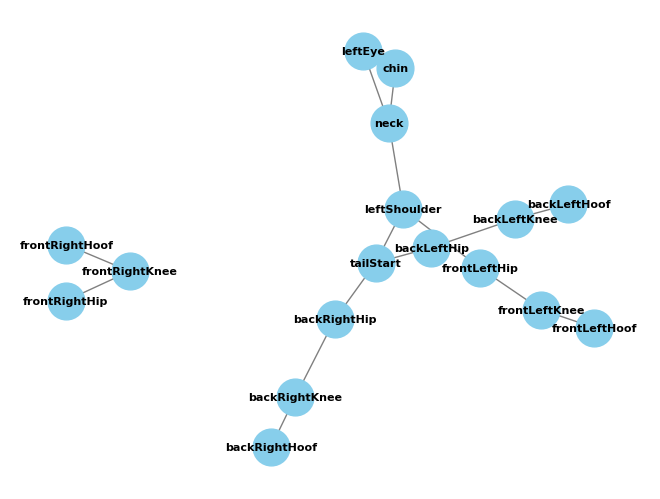

In [3]:
first_file_frame = graph_seq['740.mat'][33]
# draw the graph
# pos = nx.spring_layout(first_file_frame)
nx.draw(first_file_frame,  with_labels=True, font_weight='bold', node_size=700, 
        node_color='skyblue', font_color='black', font_size=8, edge_color='gray')

In [24]:
np.pad(adjacency_matrix(graph_seq['740.mat']), ((abs(adjacency_matrix(graph_seq['740.mat']).shape[0]-300), 0), (0, 0), (0, 0))).shape


Frame 147 has no nodes
Frame 148 has no nodes
Frame 149 has no nodes
Frame 150 has no nodes
Frame 151 has no nodes
Frame 152 has no nodes
Frame 153 has no nodes
Frame 163 has no nodes
Frame 164 has no nodes
Frame 147 has no nodes
Frame 148 has no nodes
Frame 149 has no nodes
Frame 150 has no nodes
Frame 151 has no nodes
Frame 152 has no nodes
Frame 153 has no nodes
Frame 163 has no nodes
Frame 164 has no nodes


(300, 19, 19)

In [ ]:
Video_data = []
for matr_val in graph_seq.values():
    # print(matr_val)
    Video_data.append(np.pad(adjacency_matrix(matr_val), 
                    ((abs(adjacency_matrix(matr_val).shape[0]-300), 0), (0, 0), (0, 0))))

    # print(adjacency_matrix(matr_val).shape)

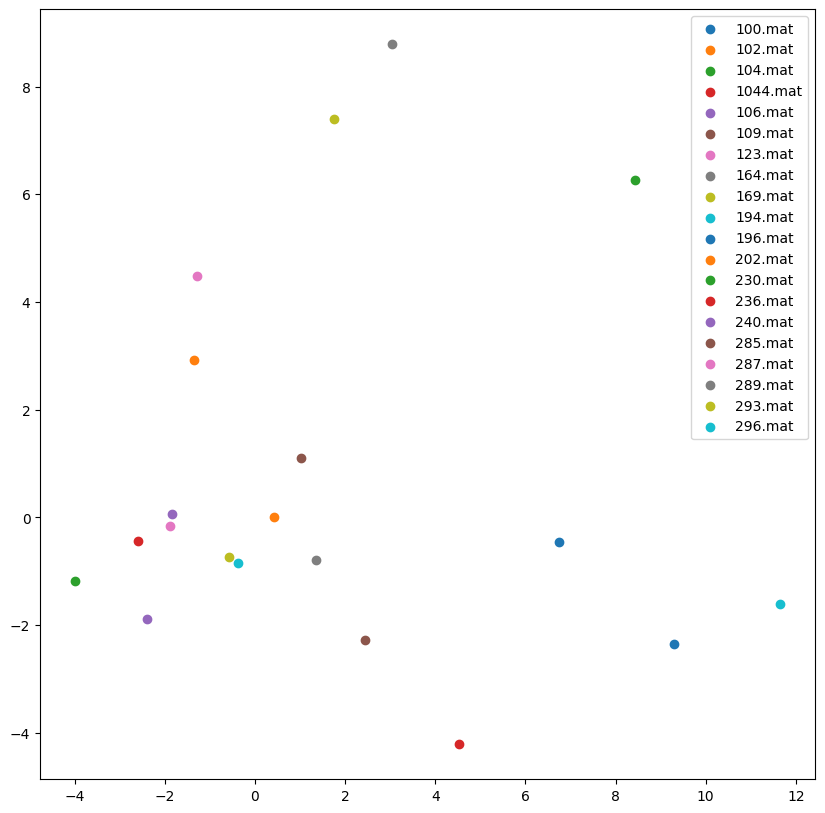

In [45]:
num_samples, num_channels, height, width = np.array(Video_data).shape
X = np.array(Video_data).reshape(num_samples, num_channels*height*width)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
pca_dict = dict(zip(graph_seq.keys(), X_pca))

count = 0
# plot the PCA_dict
plt.figure(figsize=(10,10))
for key, value in pca_dict.items():
    if count == 20:
        break
    plt.scatter(value[0], value[1], label=key)
    count += 1
plt.legend()

In [ ]:
# samples = [adjacency_matrix(matr_val) for matr_val in graph_seq.values()]

for matr_val in graph_seq.values():
    # print(matr_val)
    print(adjacency_matrix(matr_val).shape)

    

In [22]:
print(nx.get_edge_attributes(first_file_frame, 'weight'))
nx.to_dict_of_lists(first_file_frame)

{('chin', 'leftEye'): 0.1610077085776241, ('chin', 'neck'): 0.160528509815673, ('leftEye', 'neck'): 0.08983253199808003, ('neck', 'leftShoulder'): 0.16518963589352464, ('leftShoulder', 'frontLeftHip'): 0.1304471295188597, ('leftShoulder', 'tailStart'): 0.2832949654903534, ('frontLeftHip', 'frontLeftKnee'): 0.16016165944266045, ('tailStart', 'backLeftHip'): 0.24024248916399063, ('tailStart', 'backRightHip'): 0.2592522706106538, ('frontLeftKnee', 'frontLeftHoof'): 0.12505174644464861, ('frontRightHip', 'frontRightKnee'): 0.1275108824923486, ('frontRightKnee', 'frontRightHoof'): 0.13697904071558742, ('backLeftHip', 'backLeftKnee'): 0.09926285552424832, ('backRightHip', 'backRightKnee'): 0.11093704801240632, ('backLeftKnee', 'backLeftHoof'): 0.2152706519702817, ('backRightKnee', 'backRightHoof'): 0.17185466288110296}


{'chin': ['leftEye', 'neck'],
 'leftEye': ['chin', 'neck'],
 'neck': ['chin', 'leftEye', 'leftShoulder'],
 'leftShoulder': ['neck', 'frontLeftHip', 'tailStart'],
 'frontLeftHip': ['leftShoulder', 'frontLeftKnee'],
 'tailStart': ['leftShoulder', 'backLeftHip', 'backRightHip'],
 'frontLeftKnee': ['frontLeftHip', 'frontLeftHoof'],
 'frontRightHip': ['frontRightKnee'],
 'frontRightKnee': ['frontRightHip', 'frontRightHoof'],
 'frontLeftHoof': ['frontLeftKnee'],
 'frontRightHoof': ['frontRightKnee'],
 'backLeftHip': ['tailStart', 'backLeftKnee'],
 'backRightHip': ['tailStart', 'backRightKnee'],
 'backLeftKnee': ['backLeftHip', 'backLeftHoof'],
 'backRightKnee': ['backRightHip', 'backRightHoof'],
 'backLeftHoof': ['backLeftKnee'],
 'backRightHoof': ['backRightKnee']}

In [29]:
print(adjacency_matrix(graph_seq['740.mat']).shape)
np.concatenate([arr for arr in adjacency_matrix(graph_seq['740.mat'])]).shape

Frame 147 has no nodes
Frame 148 has no nodes
Frame 149 has no nodes
Frame 150 has no nodes
Frame 151 has no nodes
Frame 152 has no nodes
Frame 153 has no nodes
Frame 163 has no nodes
Frame 164 has no nodes
(156, 17, 17)
Frame 147 has no nodes
Frame 148 has no nodes
Frame 149 has no nodes
Frame 150 has no nodes
Frame 151 has no nodes
Frame 152 has no nodes
Frame 153 has no nodes
Frame 163 has no nodes
Frame 164 has no nodes


(2652, 17)

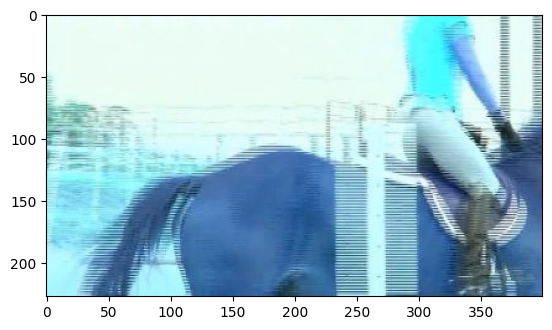

In [47]:
frame = evaluate_frame('videos/horse/740.avi', 164)

Frame 147 has no nodes
Frame 148 has no nodes
Frame 149 has no nodes
Frame 150 has no nodes
Frame 151 has no nodes
Frame 152 has no nodes
Frame 153 has no nodes
Frame 163 has no nodes
Frame 164 has no nodes


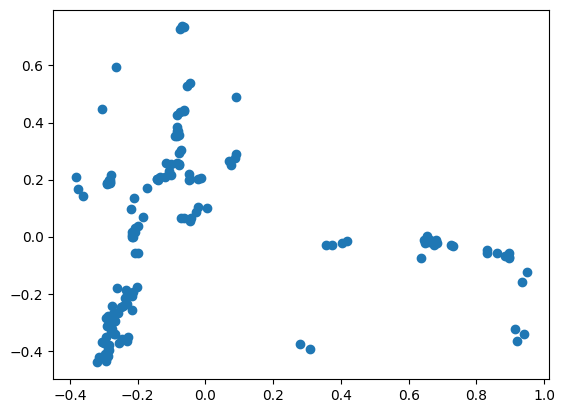

In [19]:
# reduce the dimensionality of the data
from sklearn.decomposition import PCA

# flatten the data
flatten_data = np.array([matrix.flatten() for matrix in adjacency_matrix(graph_seq['740.mat'])])

# reduce the dimensionality of the data
pca = PCA(n_components=2)
pca.fit(flatten_data)
pca_data = pca.transform(flatten_data)

# plot the data
plt.scatter(pca_data[:,0], pca_data[:,1])
plt.show()

In [ ]:
# reduce the dimensionality of the data
from sklearn.decomposition import PCA
# flatten the data
reducted_data = dict()
for key, value in graph_seq.items():
    flatten_data = np.array([matrix.flatten() for matrix in adjacency_matrix(value)])
    pca = PCA(n_components=2)
    pca.fit(flatten_data)
    reducted_data[key] = pca.transform(flatten_data)
    

In [25]:
reducted_data['100.mat'].shape

(216, 2)

In [31]:
reducted_data['100.mat'].shape

(3240, 2)

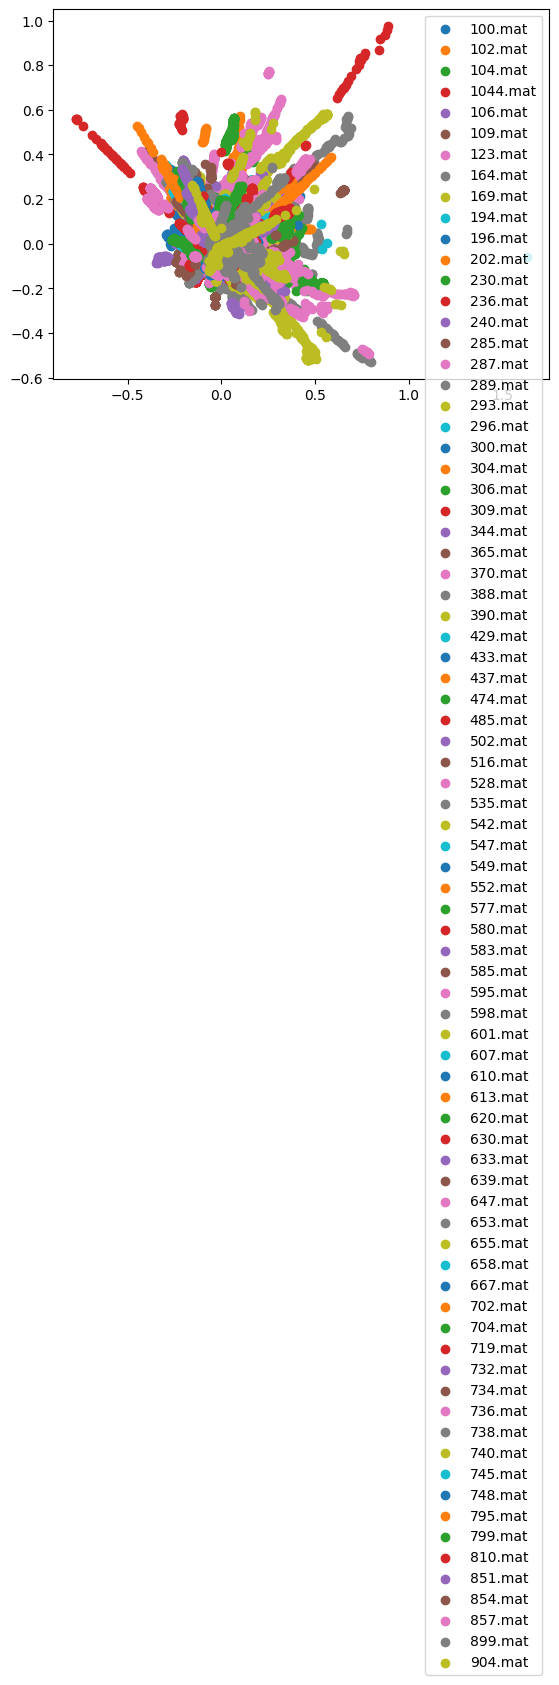

In [32]:
# plot the data
for key, value in reducted_data.items():
    plt.scatter(value[:, 0], value[:, 1], label=key)
plt.legend()

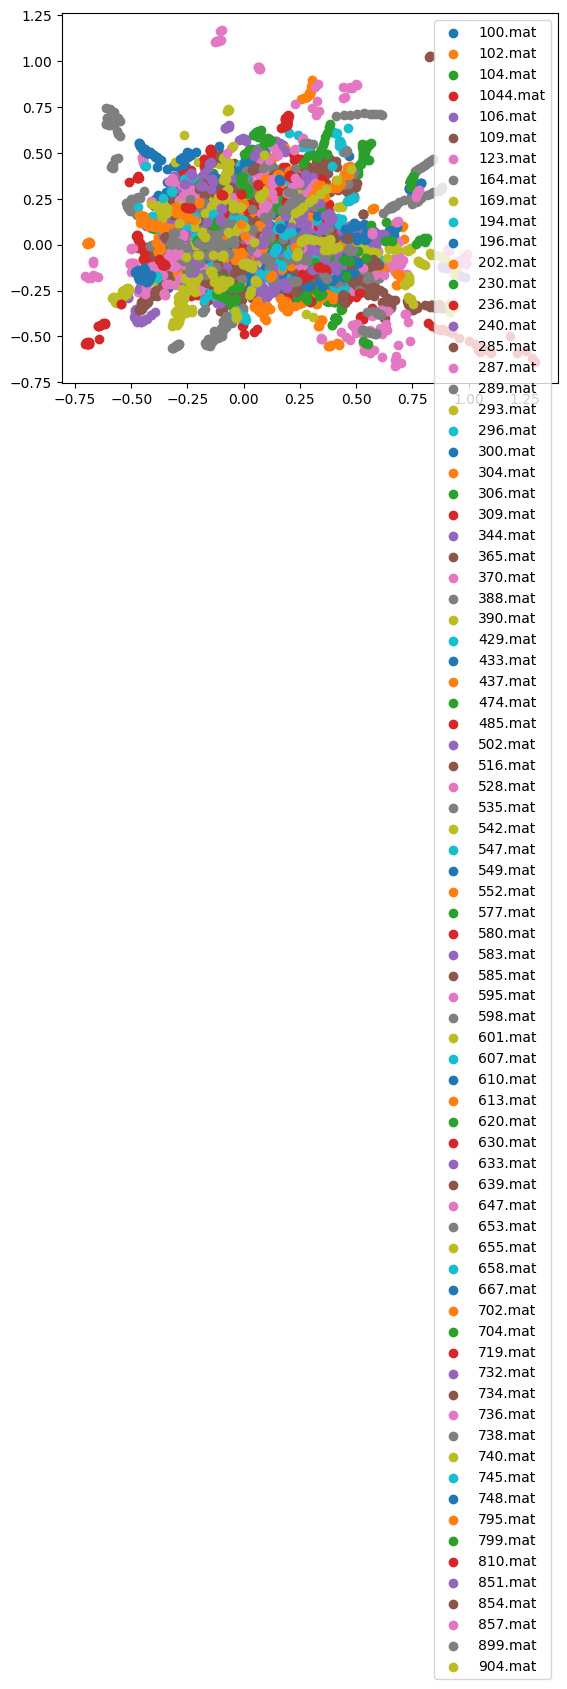

In [17]:
# plot the data
for key, value in reducted_data.items():
    plt.scatter(value[:, 0], value[:, 1], label=key)
plt.legend()

In [7]:
from node2vec import Node2Vec

# Assuming you have a graph 'G'
node2vec = Node2Vec(first_file_frame, dimensions=64, walk_length=30, num_walks=200, workers=4)


c:\Users\Austin\Desktop\Agent\animal-pose-estimation\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Computing transition probabilities: 100%|██████████| 14/14 [00:00<00:00, 7023.11it/s]


In [8]:
# Embed nodes
model = node2vec.fit(window=10, min_count=1, batch_words=4)


In [9]:
# Get the embedding for a specific node (e.g., node '0')
model.wv['backRightHoof']


array([ 0.33325917,  0.00305918,  0.35420942,  0.2822716 ,  0.14413178,
        0.11148843,  0.03489264, -0.43204358, -0.46396285, -0.23460376,
        0.27224785, -0.30610737, -0.09946018,  0.0070683 , -0.25086308,
       -0.1417854 , -0.35386586, -0.24183908, -0.10103845,  0.00663463,
        0.16304545,  0.04432049,  0.41139328, -0.05132864, -0.03199434,
        0.29398254, -0.10273346, -0.07847615, -0.6098085 , -0.19501755,
        0.31567046, -0.1822066 , -0.427661  , -0.11750152,  0.157039  ,
        0.07107908, -0.21662726, -0.01639662,  0.03435345,  0.3276718 ,
        0.12707415,  0.05521111, -0.4020276 , -0.2941857 , -0.34959775,
       -0.42693782,  0.01902929, -0.28298616, -0.07230633, -0.05376903,
        0.15689644,  0.24004437,  0.0156197 ,  0.16942976,  0.23776223,
       -0.38671082,  0.1168103 , -0.28820586, -0.13287698,  0.2586206 ,
        0.32404107, -0.49215147,  0.24345814,  0.31283587], dtype=float32)